In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy
import folium
import geopandas as gpd
from shapely.geometry import Point

df = pd.read_csv('earthquakes_2023_global.csv')
data = df.copy()



month_dict = {0: 'January', 1: 'February', 2: 'March', 3: 'April', 4: 'May', 5: 'June',
              6: 'July', 87: 'August', 8: 'September', 9: 'October', 10: 'November', 11: 'December'}

df['time'] = pd.to_datetime(df['time'].apply(lambda x: x[:-5]))
df['updated'] = pd.to_datetime(df['updated'].apply(lambda x: x[:-5]))
df.drop_duplicates( inplace= True)
# df['hour'] == df['hour'].astype('int8') everything is True I can change
df['hour'] = df['time'].dt.hour.astype('int8')
df['month'] = df['time'].dt.month.astype('category').map(month_dict)
df[['magType', 'net']] = df[['magType', 'net']].astype('category')

df['nst'].fillna(0, inplace=True) # I took NaN as 0, nobody reported (calculated localy)
df['nst'] = df['nst'].astype('int16') # df['nst'] == df['nst'].astype('int16')

# Too much RAM for these features, I also will calculate errors
df[['latitude', 'longitude', 'depth', 'gap', 'dmin', 'rms']] = \
    df[['latitude', 'longitude', 'depth', 'gap', 'dmin', 'rms']].astype('float32')

''' 
-- After float16 it gives me 3.099609 this kind numbers, if round it I will get back float64 type -- 
df['mag'] = df['mag'].astype('float16').apply(lambda x: round(x, 2)) 
'''
# df['id'] = df['id'].apply(lambda x: x[:2]) --> df['id'] == df['net'] 
df.drop('id', axis = 1, inplace= True)
# there is just 1 - landslide and 2 - Landslide
df['type'] = df['type'].replace('landslide', 'Landslide')

In [35]:
((data['depth'] - df['depth']) * 1000 * 100).describe()

count    24682.000000
mean         0.000544
std          0.362034
min         -3.027344
25%         -0.015259
50%          0.000000
75%          0.015259
max          3.027344
Name: depth, dtype: float64

In [36]:
def clean_place(x):
    
    # if sentence starts from num, I will get True, for '23 km ESE of ...'
    def check_num(y):
        return True if any(char.isdigit() for char in y) else False
    
    # if func check_num is True, there is format - xx km till place or region, another region, country
    # it works only with this kind of strings - '59 km SSW of Unalaska'
    def taking_km(y):
        y = y.split(' ') 
        # it might looks similar and useless, but there is 2 ways how to write num with km 
        if any(char.isdigit() for char in y[0]) and any(char.isalpha() for char in y[0]): # -- without space, like 5km
            km_till_e = y[0][:-2] + ' ' + y[1]
            reg_from_km = ' '.join(y[3:])
        else: # with space like 5 km
            km_till_e = y[0] + ' ' + y[2]
            reg_from_km = ' '.join(y[4:])
        return km_till_e, reg_from_km
    
    region = None
    km_till_earq = None
    country = None
    
    if ',' in x: 
        splitted = x.split(',')
        if len(splitted) == 3: # then there is 2 ',' it means it has format: area or region, second region, country
           country =  splitted[2] 
           region = splitted[1] + ',' + splitted[0]
        if len(splitted) == 2: # it might has 2 positons
            # second place, it is region or country
            if 'reg' not in splitted[1]:
                country = splitted[1]
            else:
                region = splitted[1]
            # for first place, it is km till area or region
            if check_num(splitted[0]):
                km_till_earq, region = taking_km(splitted[0])
            else: region = splitted[0]
    else: # no any ',' then it might be some km till area or region or country
        if check_num(x): # some km till region
            km_till_earq, region = taking_km(x)   
        elif 'reg' not in x: 
                country = x
        else:
            region = x         
    return region, km_till_earq, country

In [37]:
df['place'].fillna(' ', inplace= True)
# I apply function for separation region, country and km, I got some spaces after applying
df[['region', 'km', 'country']] = df['place'].apply(lambda x: pd.Series(clean_place(x))).apply(lambda x: x.str.strip())  

Text(0.5, 0, 'By months')

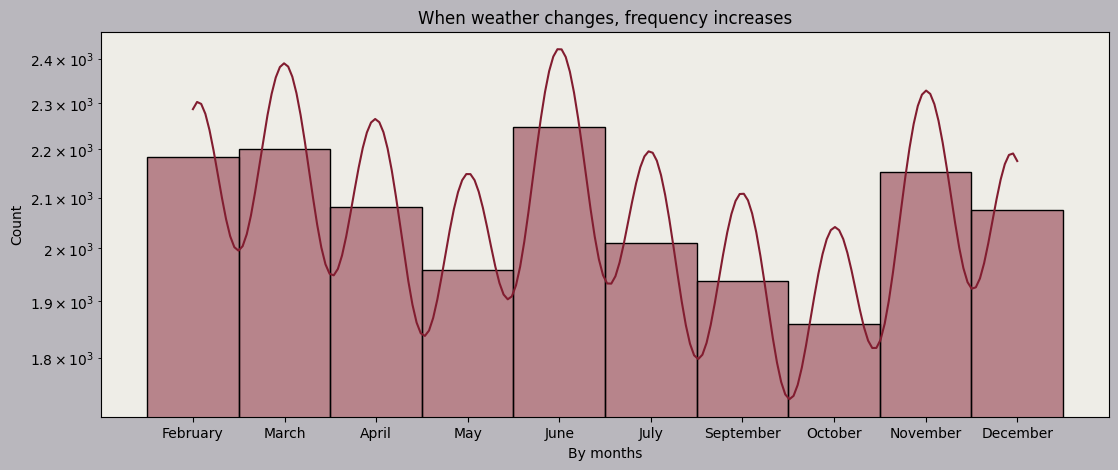

In [38]:
# by month 
fig, ax = plt.subplots(figsize=(13, 5), facecolor = '#B9B7BD')
ax.set_facecolor("#EEEDE7")
sns.histplot(df['month'], kde = True, color = '#821D30')
plt.yscale('log')
plt.title('When weather changes, frequency increases')
plt.xlabel('By months')

Text(0.5, 0, '')

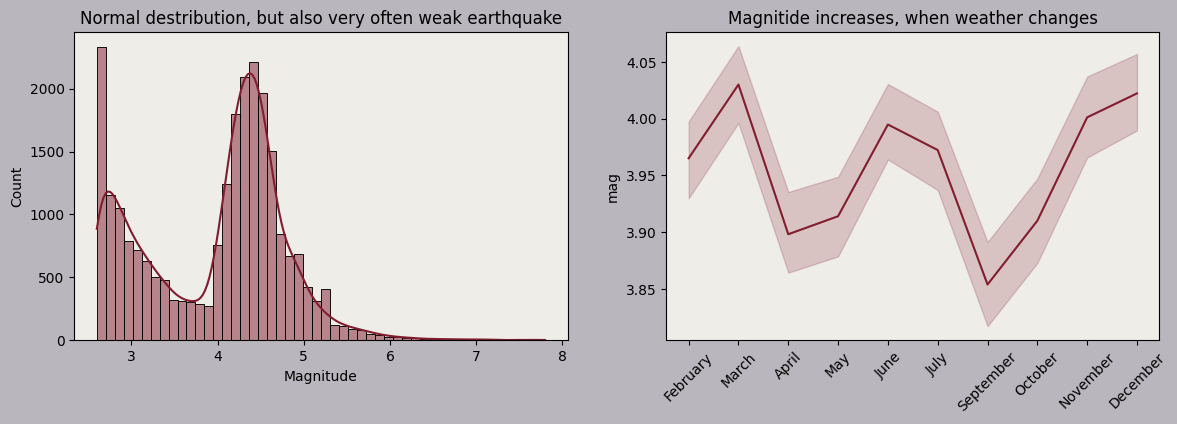

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), facecolor='#B9B7BD')

# Plotting on the first axis (ax[0])
sns.histplot(df['mag'], kde=True, ax=ax[0],color = '#821D30', bins = 50)
ax[0].set_facecolor("#EEEDE7")
ax[0].set_xlabel('Magnitude')
ax[0].set_title('Normal destribution, but also very often weak earthquake')

# Plotting on the second axis (ax[1])
sns.lineplot(data=df, x='month', y='mag', ax=ax[1], color = '#821D30')
ax[1].set_facecolor("#EEEDE7")
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('Magnitide increases, when weather changes')
ax[1].set_xlabel('')

Text(0.5, 0, '')

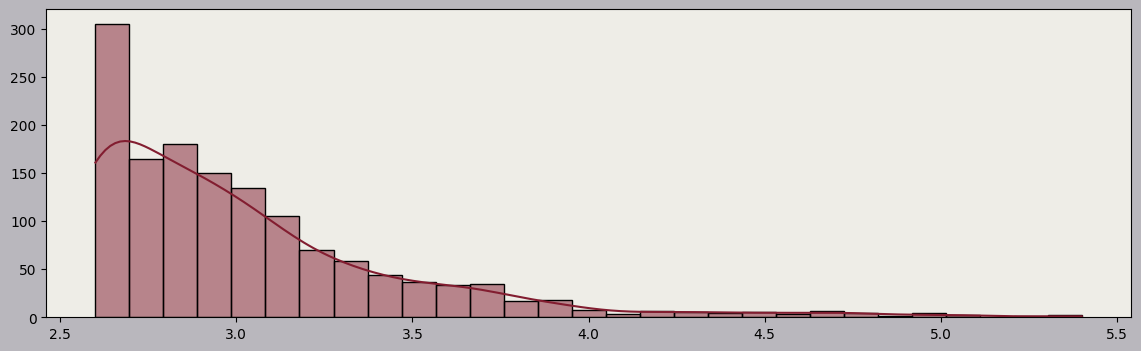

In [40]:
# 0 stations reported
x = df[df['nst'] == 0]
fig, ax = plt.subplots(1, 1, figsize=(14, 4), facecolor='#B9B7BD')
ax.set_facecolor("#EEEDE7")
sns.histplot(x['mag'], bins = 29, color='#821D30', kde = True)
ax.set_ylabel('')
ax.set_xlabel('')

Text(0.5, 0, 'Min distance to event')

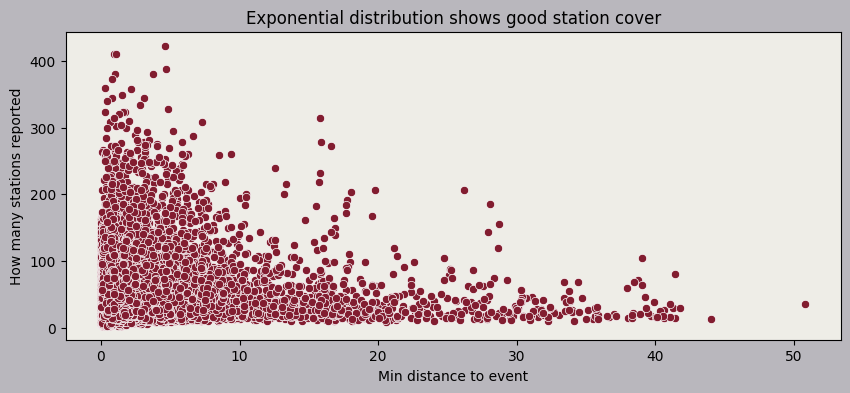

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), facecolor='#B9B7BD')
ax.set_facecolor("#EEEDE7")
sns.scatterplot(df, x = 'dmin', y = 'nst', color='#821D30')
ax.set_title('Exponential distribution shows good station cover')
ax.set_ylabel('How many stations reported')
ax.set_xlabel('Min distance to event')